In [6]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

This file aims to create TTV signals to validate 1st order MMR code with regimes
- Eccentricities: 0.01 to 0.3 / Uniform log e
- Longitudes of periastron: 0 to 360 deg / Uniform w
- MMRs: 2:1, 3:2, 4:3, 5:4 / Uniform
- Deltas: Depends on j / Uniform
- Planet masses: 0.3 to 300 Earth masses / Uniform log m

If system with invalid regime e >~ Delta^2 / mu is detected, then DO NOT SIMULATE.

In [7]:
# Evaluate Delta boundary for each j
def periodRatio(j):
    return j/(j-1)

def minmaxDelta(j):
    if j == 2:
        maxPeriodRatio = np.nan
        maxDelta = 0.2
    else:
        maxPeriodRatio = 0.5 * (periodRatio(j) + periodRatio(j-1))
        maxDelta = (j-1)/j * maxPeriodRatio - 1

    minPeriodRatio = 0.5 * (periodRatio(j) + periodRatio(j+1))
    minDelta = (j-1)/j * minPeriodRatio - 1
    
    return minDelta, maxDelta

minmaxDeltas = pd.DataFrame(
    [[j, *minmaxDelta(j)] for j in (2, 3, 4, 5)],
    columns=['j', 'min_Delta', 'max_Delta']
)

# Build lookup dictionaries once for Dynamic Delta sampling
minmaxDeltas['min_Delta_used'] = [0.020, 0.010, 0.005, 0.005]
minmaxDeltas['max_Delta_used'] = [0.050, 0.020, 0.015, 0.010]
minDelta_lookup = dict(zip(minmaxDeltas['j'], minmaxDeltas['min_Delta_used']))
maxDelta_lookup = dict(zip(minmaxDeltas['j'], minmaxDeltas['max_Delta_used']))

# Show df
minmaxDeltas.head()

,j,min_Delta,max_Delta,min_Delta_used,max_Delta_used
0,2,-0.125000,0.200000,0.020,0.050
1,3,-0.055556,0.166667,0.010,0.020
2,4,-0.031250,0.062500,0.005,0.015
3,5,-0.020000,0.033333,0.005,0.010


In [8]:
# Create 50000 samples
size = 50000
mstar = 1

e1 = 10 ** np.random.uniform(low=-2, high=-0.5, size=size)
e2 = 10 ** np.random.uniform(low=-2, high=-0.5, size=size)
w1 = np.random.uniform(low=0, high=360, size=size)
w2 = np.random.uniform(low=0, high=360, size=size)

j = np.random.choice([2, 3, 4, 5], size=size)
Delta_low = np.array(pd.Series(j).map(minDelta_lookup))
Delta_high = np.array(pd.Series(j).map(maxDelta_lookup))

Delta = np.random.uniform(low=Delta_low, high=Delta_high, size=size) * np.random.choice([-1, 1], size=size)
P1 = 7
P2 = P1 * (Delta + 1) * j / (j-1)

m1 = 10 ** np.random.uniform(low=-0.5, high=2.5, size=size)
m2 = 10 ** np.random.uniform(low=-0.5, high=2.5, size=size)

mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value

e_max = np.maximum(e1, e2)
validity1 = Delta**2 / (mu2 * e_max)
validity2 = Delta**2 / (mu1 * e_max)
validity_threshold = 100

# Create valid mask
valid = (validity1 > validity_threshold) & (validity2 > validity_threshold)
valid_percent = valid.mean() * 100

# Compile to dataframe
df = pd.DataFrame({
    'e1': e1, 'w1': w1,
    'e2': e2, 'w2': w2,
    'Delta': Delta, 'j': j,
    'P1': 7, 'P2': P2,
    'm1': m1, 'm2': m2,
    'mu1': mu1, 'mu2': mu2,
    'validity1': validity1, 'validity2': validity2,
    'valid': valid
})
df.head()

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
0,0.217826,125.098870,0.011114,250.839745,0.008372,5,7,8.823254,34.522853,7.794373,0.000104,0.000023,13.744474,3.103149,False
1,0.043071,109.337070,0.042463,146.170882,-0.046252,2,7,13.352477,14.587718,1.592966,0.000044,0.000005,10380.979802,1133.593878,True
2,0.013426,149.951647,0.018693,68.549390,-0.032123,2,7,13.550281,2.894622,51.337945,0.000009,0.000154,357.999885,6349.353063,True
3,0.168492,198.228783,0.048897,10.946683,-0.030239,2,7,13.576657,103.900720,13.887060,0.000312,0.000042,130.110252,17.390148,False
4,0.012973,158.697509,0.027805,112.138555,-0.007286,4,7,9.265328,23.031962,1.107622,0.000069,0.000003,573.937740,27.601051,False


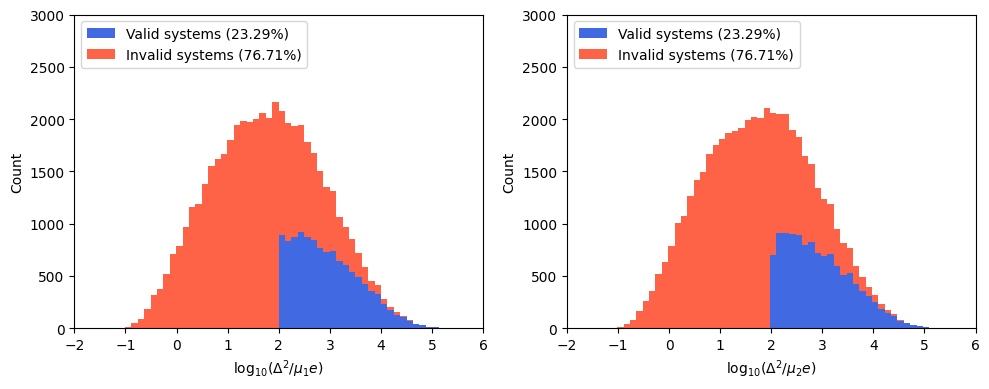

In [9]:
# Histogram of validity condition
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fmt = lambda x: f"{x:.2f}".rstrip("0").rstrip(".")
labels = [f"Valid systems ({fmt(valid_percent)}%)", f"Invalid systems ({fmt(100-valid_percent)}%)"]
colors = ["royalblue", "tomato"]
xlim = (-2, 6); ylim = (0, 3000)

# Left histogram
ax[0].hist([np.log10(validity1[valid]), np.log10(validity1[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[0].set_xlabel('log$_{10}$($\Delta^2 / \mu_1 e$)')
ax[0].set_ylabel('Count')
ax[0].set_xlim(xlim); ax[0].set_ylim(ylim)
ax[0].legend(loc='upper left')

# Right histogram
ax[1].hist([np.log10(validity2[valid]), np.log10(validity2[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[1].set_xlabel('log$_{10}$($\Delta^2 / \mu_2 e$)')
ax[1].set_ylabel('Count')
ax[1].set_xlim(xlim); ax[1].set_ylim(ylim)
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [10]:
# Export dataframe
df.to_csv("lithwick_TTVFast_params.csv", index=False)